In [1]:
#Importar Librerias
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#Carga de los datos
pdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
trusted_dir = os.path.join(pdir,"data","trusted")
df = pd.read_csv(os.path.join(trusted_dir,"dengue_data.csv" ))
df.shape

(174876, 33)

In [4]:
df["fecha"] = pd.to_datetime(df.Year.astype("str") + "-" + df.Month_num.astype("str") + "-01" )

In [5]:
df_rezagos = pd.DataFrame()

for code in df["Municipality code"].unique():
  tmp = df.loc[df["Municipality code"] == code, :].copy()
  # se agregan los rezagos
  for i in range(1,13):
      columna = 'rezago_' + str(i)
      tmp[columna] = tmp['Cases'].shift(i)
      columna2 = 'temp_rezago_' + str(i)
      tmp[columna2] = tmp['TEMPERATURE'].shift(i)
      columna3 = 'prec_rezago_' + str(i)
      tmp[columna3] = tmp['PRECIPITATION'].shift(i)

  df_rezagos = df_rezagos.append(tmp)
df = df_rezagos 

C:\Users\franc\AppData\Local\Temp\ipykernel_15532\1419093067.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_15532\1419093067.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_15532\1419093067.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_15532\1419093067.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_

In [6]:
df.dropna(inplace=True)
df.set_index("fecha", inplace=True)

In [7]:
df_original = df 

In [8]:
df = df[["TEMPERATURE",	"rezago_1",	"prec_rezago_8",	"temp_rezago_12", "Cases"]]
df = df.reset_index().groupby("fecha").mean()

In [9]:
#Se escalan los datos 
X, Y = df.drop(columns="Cases").copy(), df[["Cases"]].copy()

scaler_x = MinMaxScaler()
scaler_x.fit(X.values)
X = pd.DataFrame(data= scaler_x.transform(X.values), columns = X.columns, index = X.index)

#scaler_y = MinMaxScaler()
#scaler_y.fit(Y.values)
#Y = pd.DataFrame(data=scaler_y.transform(Y.values), columns = Y.columns, index=Y.index)

In [10]:
#Se separan los datos en train y test, haciendo una partición a manera de serie de tiempo
tmonths = np.unique(list(X.index)) #Número de meses totales
lim = 12 #Número de meses que se desean predecir

X_train = X.loc[:pd.to_datetime(tmonths[len(tmonths)-lim-1]),:]
y_train = Y.loc[:pd.to_datetime(tmonths[len(tmonths)-lim-1]),:]
X_test = X.loc[pd.to_datetime(tmonths[len(tmonths)-lim]):,:]
y_test = Y.loc[pd.to_datetime(tmonths[len(tmonths)-lim]):,:]

In [11]:
#Se crea una función de ayuda para invertir la normalización del MinMaxScaler
def inv_scaler(df):
  data = scaler_x.inverse_transform(df)
  return pd.DataFrame(data=data, columns = df.columns, index= df.index)

### **Trainning and Fine Tuning**

Se entrenan diferentes algoritmos y se ajustan sus hiperparametos

#### **LinearRegression**

In [12]:
lr=LinearRegression()
scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error"]
scores = cross_validate(lr, X_train, y_train, scoring=scoring, return_train_score=True)
print(scores['test_neg_root_mean_squared_error'].mean()*-1)

1.2636590161268335


#### **RandomForest**

In [13]:
rf = RandomForestRegressor(random_state=42)
scores_rf = cross_validate(rf, X_train, y_train.Cases, scoring=scoring, return_train_score=True)
print(scores_rf['test_neg_root_mean_squared_error'].mean()*-1)

1.7640220618026787


#### **Gradient Boosting (XGBoost)**

In [14]:
gb = XGBRegressor(objective='reg:squarederror')
scores_gb = cross_validate(gb,X_train, y_train.Cases, scoring=scoring, return_train_score=True)
print(scores_gb['test_neg_root_mean_squared_error'].mean()*-1)

1.767599695181125


### **Model Training**

Se entrenan todos los modelos 

# **Linear Regression**

In [15]:
lr=LinearRegression().fit(X_train,y_train)
y_lr = lr.predict(X_test)
y_lr = pd.DataFrame(data= y_lr, columns = y_test.columns, index= y_test.index)
np.sqrt(mean_squared_error(y_test, y_lr))

0.9484634736247521

In [16]:
print(lr.coef_[0])
print(lr.intercept_)

[ 3.91595838 16.43395081  0.92908065 -2.43144495]
[1.11033511]


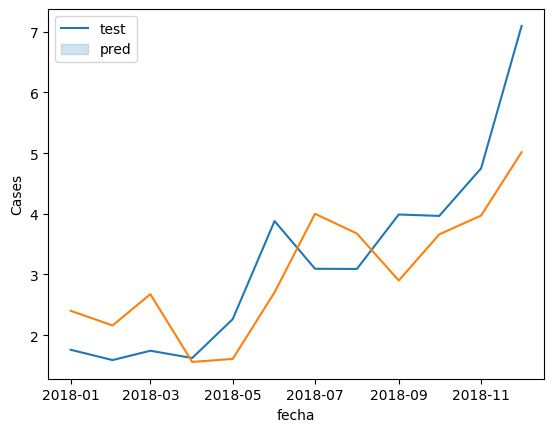

In [17]:
sns.lineplot(data= y_test.reset_index(), x= "fecha", y="Cases")
sns.lineplot(data=y_lr.reset_index(), x= "fecha", y="Cases")
plt.legend(["test", "pred"]);

In [18]:
rf = RandomForestRegressor(random_state=42).fit(X_train,y_train.Cases)
y_rf = rf.predict(X_test)
y_rf = pd.DataFrame(data= y_rf, columns = y_test.columns, index= y_test.index)
np.sqrt(mean_squared_error(y_test, y_rf))

1.06758415263833

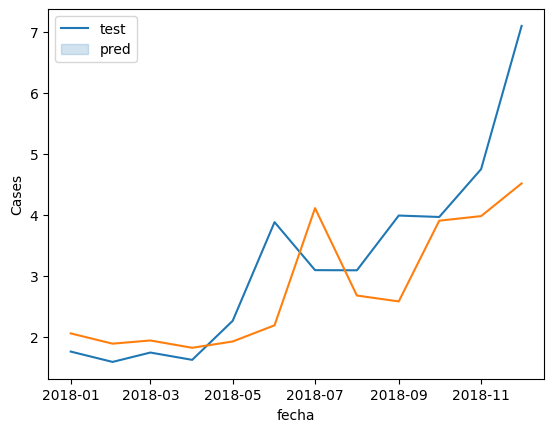

In [19]:
sns.lineplot(data= y_test.reset_index(), x= "fecha", y="Cases")
sns.lineplot(data=y_rf.reset_index(), x= "fecha", y="Cases")
plt.legend(["test", "pred"]);

In [20]:
gb = XGBRegressor(objective='reg:squarederror').fit(X_train,y_train.Cases)
y_gb = gb.predict(X_test)
y_gb = pd.DataFrame(data= y_gb, columns = y_test.columns, index= y_test.index)
np.sqrt(mean_squared_error(y_test, y_gb))

1.118762329432725

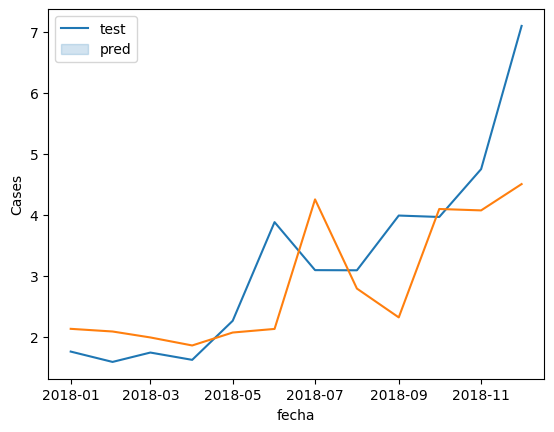

In [21]:
sns.lineplot(data= y_test.reset_index(), x= "fecha", y="Cases")
sns.lineplot(data=y_gb.reset_index(), x= "fecha", y="Cases")
plt.legend(["test", "pred"]);

Se observa que la regresión lineal supera en desempeño a los otros modelos, además, es evidente que el error de test es menor al valor de train. Esto puede deberse a la forma de particionar los datos. Al separarlos de manera secuencial debido a su dependencia de tiempo, el set de test puede presentar casos más "sencillos" que el set de entrenamiento. 




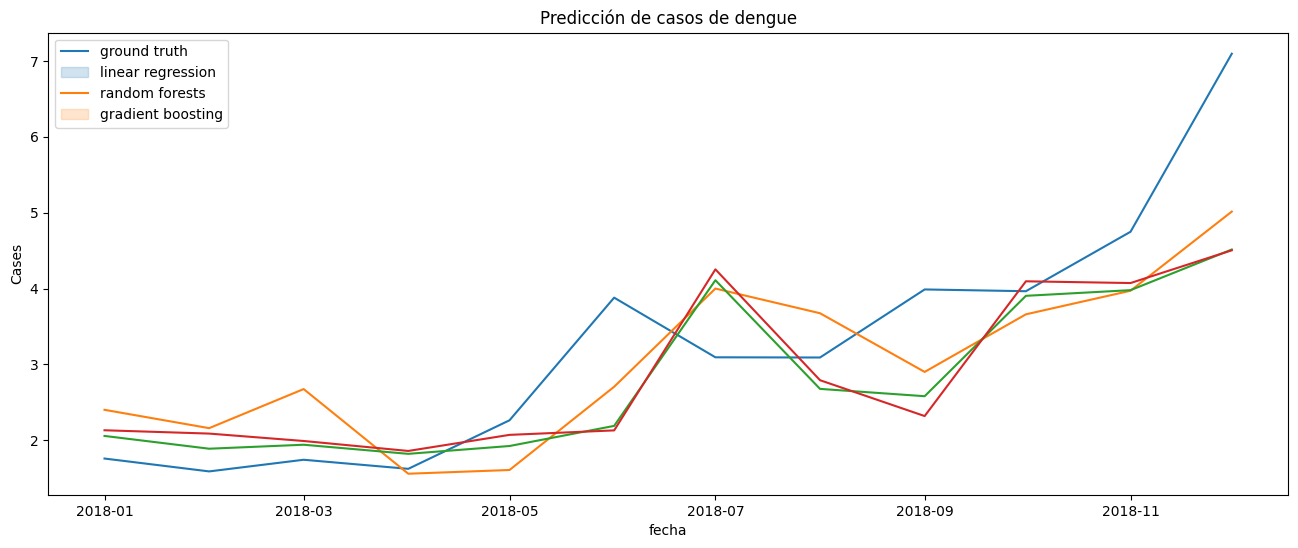

In [22]:
plt.figure(figsize=(16,6))
sns.lineplot(data= df.loc[pd.to_datetime("2018-01-01"):, "Cases"].reset_index(), x= "fecha", y="Cases")
sns.lineplot(data=y_lr.reset_index(), x= "fecha", y="Cases")
sns.lineplot(data=y_rf.reset_index(), x= "fecha", y="Cases")
sns.lineplot(data=y_gb.reset_index(), x= "fecha", y="Cases")
plt.legend(["ground truth", "linear regression", "random forests", "gradient boosting"]);
plt.title("Predicción de casos de dengue");

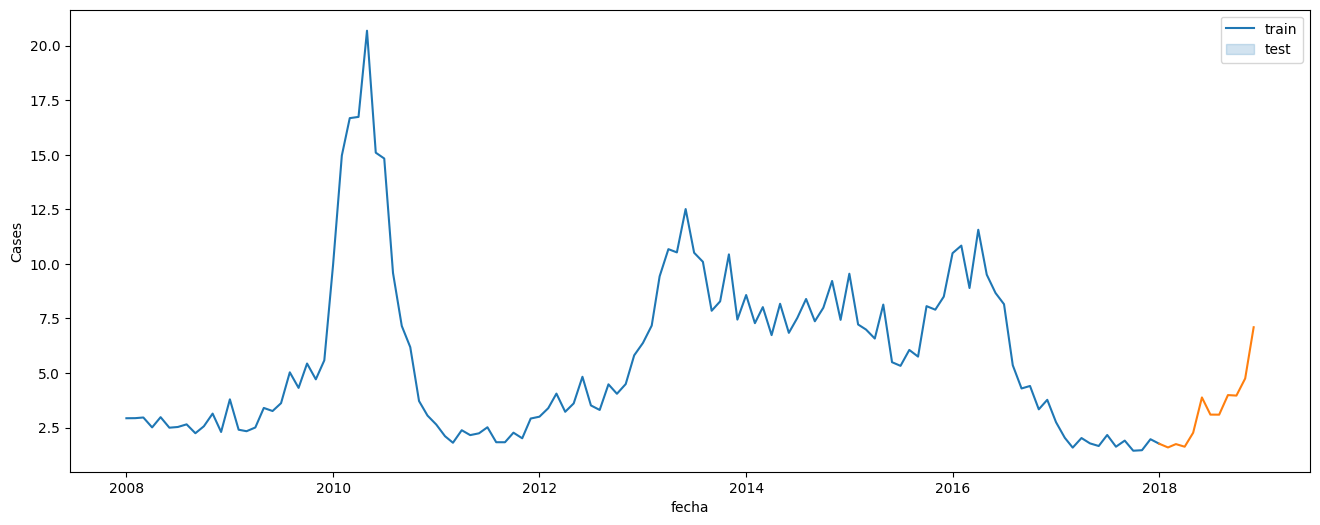

In [23]:
plt.figure(figsize=(16,6))
sns.lineplot(data= df.loc[:pd.to_datetime("2018-01-01"), "Cases"].reset_index(), x= "fecha", y="Cases")
sns.lineplot(data= df.loc[pd.to_datetime("2018-01-01"):, "Cases"].reset_index(), x= "fecha", y="Cases")
plt.legend(["train", "test"]);


#### **Transfer Learning Experiments**

Se emplea el modelo entrenado en diferentes municipios

In [24]:
model = lr

**Medellín**

In [25]:
#Se hace un experimento con el modelo entrenado con el promedio de los datos en diferentes municipios 
time_ind = pd.to_datetime("2018-01-01")
y_med = df_original.query("Municipality == 'Medellín'").loc[time_ind:, ["Cases"]]
med = df_original.query("Municipality == 'Medellín'").loc[:,["TEMPERATURE",	"rezago_1",	"prec_rezago_8",	"temp_rezago_12"] ]
med = pd.DataFrame(data=scaler_x.transform(med.values), columns=med.columns, index=med.index).loc[time_ind:,:]

In [26]:
y_pred_med = lr.predict(med)
y_pred_med = pd.DataFrame(data= y_pred_med, columns = y_med.columns, index= y_med.index)
np.sqrt(mean_squared_error(y_med, y_pred_med))

18.491984275099888

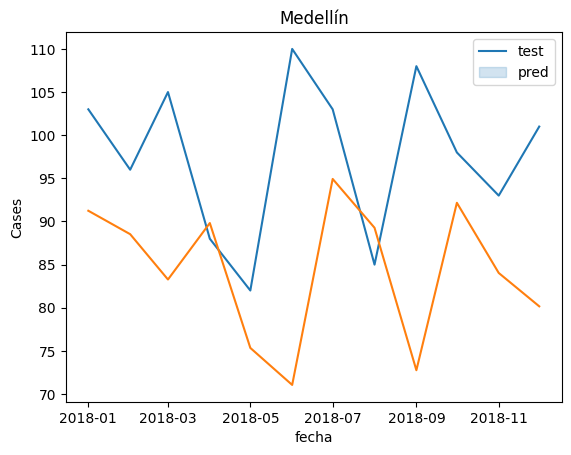

In [27]:

sns.lineplot(data= y_med, x= "fecha", y="Cases")
sns.lineplot(data= y_pred_med, x= "fecha", y="Cases")
plt.legend(["test", "pred"]);
plt.title("Medellín");

**Quibdó**

In [28]:
time_ind = pd.to_datetime("2018-01-01")
y_uib = df_original.query("Municipality == 'Quibdó'").loc[time_ind:, ["Cases"]]
uib = df_original.query("Municipality == 'Quibdó'").loc[:,["TEMPERATURE",	"rezago_1",	"prec_rezago_8",	"temp_rezago_12"] ]
uib = pd.DataFrame(data=scaler_x.transform(uib.values), columns=uib.columns, index=uib.index).loc[time_ind:,:]

In [29]:
y_pred_uib = lr.predict(uib)
y_pred_uib = pd.DataFrame(data= y_pred_uib, columns = y_uib.columns, index= y_uib.index)

In [30]:
np.sqrt(mean_squared_error(y_uib, y_pred_uib))

4.712164300710057

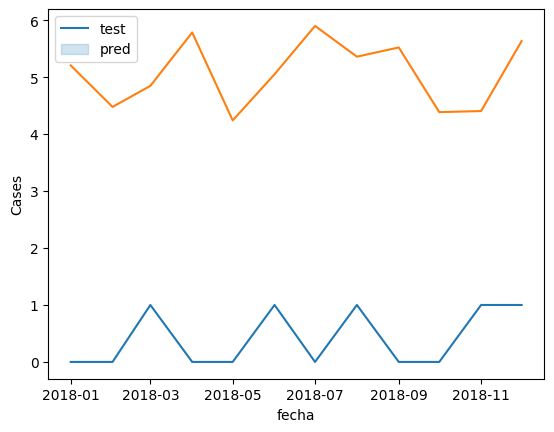

In [31]:
sns.lineplot(data= y_uib, x= "fecha", y="Cases")
sns.lineplot(data= y_pred_uib, x= "fecha", y="Cases")
plt.legend(["test", "pred"]);

**Barranquilla**

In [32]:
time_ind = pd.to_datetime("2018-01-01")
y_barr = df_original.query("Municipality == 'Barranquilla'").loc[time_ind:, ["Cases"]]
barr = df_original.query("Municipality == 'Barranquilla'").loc[:,["TEMPERATURE",	"rezago_1",	"prec_rezago_8",	"temp_rezago_12"] ]
barr = pd.DataFrame(data=scaler_x.transform(barr.values), columns=barr.columns, index=barr.index).loc[time_ind:,:]

In [33]:
y_pred_barr = lr.predict(barr)
y_pred_barr = pd.DataFrame(data= y_pred_barr, columns = y_barr.columns, index= y_barr.index)
np.sqrt(mean_squared_error(y_barr, y_pred_barr))

62.03143931347202

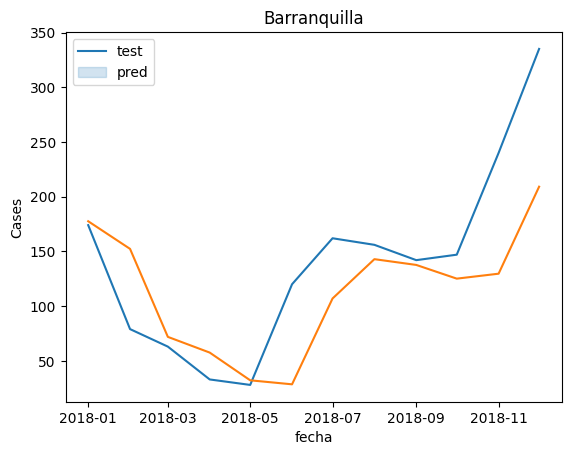

In [34]:
sns.lineplot(data= y_barr, x= "fecha", y="Cases")
sns.lineplot(data= y_pred_barr, x= "fecha", y="Cases")
plt.legend(["test", "pred"]);
plt.title("Barranquilla");

**Quindío**

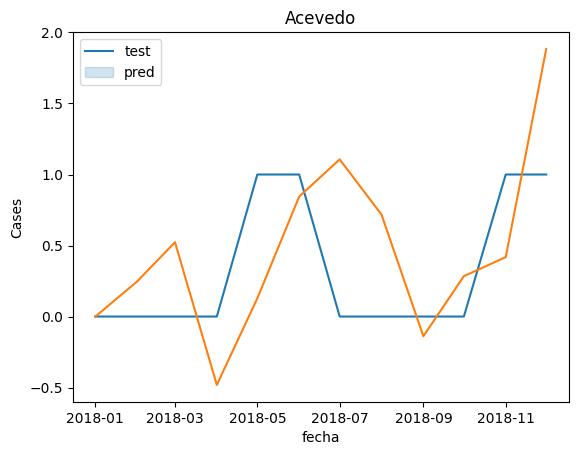

In [35]:
time_ind = pd.to_datetime("2018-01-01")
y_barr = df_original.query("Municipality == 'Acevedo'").loc[time_ind:, ["Cases"]]
barr = df_original.query("Municipality == 'Acevedo'").loc[:,["TEMPERATURE",	"rezago_1",	"prec_rezago_8",	"temp_rezago_12"] ]
barr = pd.DataFrame(data=scaler_x.transform(barr.values), columns=barr.columns, index=barr.index).loc[time_ind:,:]

y_pred_barr = lr.predict(barr)
y_pred_barr = pd.DataFrame(data= y_pred_barr, columns = y_barr.columns, index= y_barr.index)
np.sqrt(mean_squared_error(y_barr, y_pred_barr))

sns.lineplot(data= y_barr, x= "fecha", y="Cases")
sns.lineplot(data= y_pred_barr, x= "fecha", y="Cases")
plt.legend(["test", "pred"]);
plt.title("Acevedo");

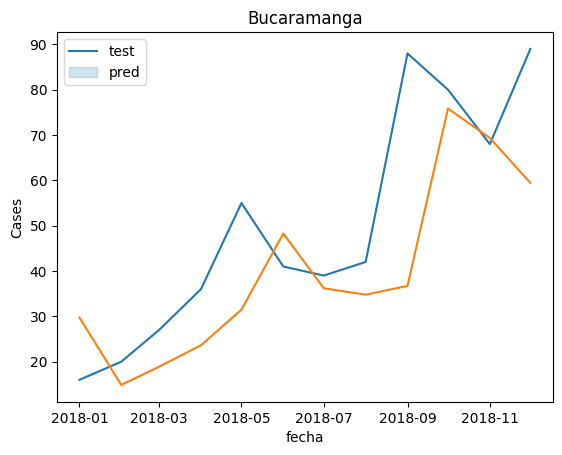

In [36]:
time_ind = pd.to_datetime("2018-01-01")
y_barr = df_original.query("Municipality == 'Bucaramanga'").loc[time_ind:, ["Cases"]]
barr = df_original.query("Municipality == 'Bucaramanga'").loc[:,["TEMPERATURE",	"rezago_1",	"prec_rezago_8",	"temp_rezago_12"] ]
barr = pd.DataFrame(data=scaler_x.transform(barr.values), columns=barr.columns, index=barr.index).loc[time_ind:,:]

y_pred_barr = lr.predict(barr)
y_pred_barr = pd.DataFrame(data= y_pred_barr, columns = y_barr.columns, index= y_barr.index)
np.sqrt(mean_squared_error(y_barr, y_pred_barr))

sns.lineplot(data= y_barr, x= "fecha", y="Cases")
sns.lineplot(data= y_pred_barr, x= "fecha", y="Cases")
plt.legend(["test", "pred"]);
plt.title("Bucaramanga");